In [1]:
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gp
import os
os.unsetenv('PROJ_LIB')
class Object(object):
    pass

In [2]:
from shapely.geometry import LineString
from itertools import chain
def mls2ls(sls):
    if any(sls.geometry.geom_type=='MultiLineString'):
        mls = sls[sls.geometry.geom_type=='MultiLineString'].copy()
        def mls2ls(row): # this looks ridiculous
            return LineString(zip(*[list(chain.from_iterable(arr)) for arr in list(zip(*[list(zip(*zip(*xy))) for xy in [l.xy for l in row.geoms]]))]))
        mls.geometry = [mls2ls(row) for row in mls['geometry'].copy()]#mls.apply(lambda row : mls2ls(row),axis=1)
        #sls[sls.geometry.geom_type=='MultiLineString'] = mls
    return mls

In [3]:
def rotate_shoreline(xin,yin,angle='auto',flipud=-1,fliplr=1):
    '''This function takes points (x,y) and rotates them by an angle
    The angle is automatically generated by the end points of the shorelines coordinates
    If this approach doesnt work for some reason you may input an angle manually (in degrees).'''

    # Get the sorted indices of x
    # sorted_indices = np.argsort(xin)
    
    # Sort x and reorder y accordingly
    # x = np.array([xin[j] for j in sorted_indices])#x[sorted_indices]
    # y = np.array([yin[j] for j in sorted_indices])#y[sorted_indices]

    x = np.array(xin)
    y = np.array(yin)
    
    if angle == 'auto':
        sign = -1 if y[-1]>y[0] else 1
        a = sign*np.arctan((y[-1]-y[0])/(x[-1]-x[0]))
    else:
        a = angle*np.pi/180
    # using this rotation matix
    xnew = (x ) * np.cos(a) - (y ) * np.sin(a)  
    ynew = (x ) * np.sin(a) + (y ) * np.cos(a) 
    return fliplr*xnew,flipud*ynew,np.degrees(a)

In [4]:
def renorm(x,y,angle,mult=100):
    x,y = x-min(x),y-min(y)    
    return mult*x/max(max(x),max(y)),mult*y/max(max(x),max(y)),angle

In [5]:
def writePts2Txt(x,y,filename):
    with open(filename, "w") as file:
        for index in range(len(x)):
            file.write(str(x[index]) + " " + str(y[index]) + "\n")
        file.seek(file.tell() - 1, 0)
        file.truncate()

def appendPts2Txt(x,y,filename):
    with open(filename, "a") as file:
        file.write(str("\n\n"))
        for index in range(len(x)):
            file.write(str(x[index]) + " " + str(y[index]) + "\n")
        file.seek(file.tell() - 1, 0)
        file.truncate()

In [6]:
inlet = Object()
spit = Object()
cape = Object()

inlet.gdf = gp.read_file("data/inlet.gpkg")
spit.gdf = gp.read_file("data/ukrainespit.gdb",layer="spitoutline")
cape.gdf = gp.read_file("data/ukrainespit.gdb",layer="nantucketcape")

ERROR 1: PROJ: proj_create_from_database: Open of /home/jupyter-dylan.mcdougall@du-ce906/.conda/envs/mypymt-cem/share/proj failed


The features were digitized with a spacing approximately 1/100th the length of the region of interest

<br><br><br><br><br>

In [7]:
ls = mls2ls(inlet.gdf).geometry

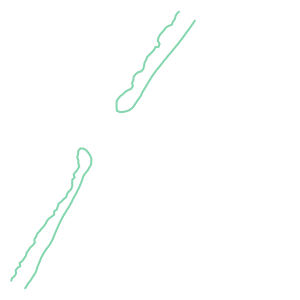

In [8]:
ls.union_all()

In [9]:
# auto angle is -54.83686360299726
inlet.x,inlet.y,inlet.angle = renorm(*rotate_shoreline(np.array(ls[0].xy[0]+ls[1].xy[0]),np.array(ls[0].xy[1]+ls[1].xy[1]),-57.4))

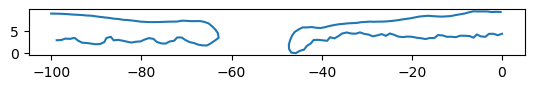

In [10]:
plt.plot(-inlet.x[:102],inlet.y[:102],c='tab:blue')
plt.plot(-inlet.x[103:],inlet.y[103:],c='tab:blue')
plt.gca().set_aspect('equal')

In [11]:
writePts2Txt(inlet.x[:102],inlet.y[:102],'data/inlet.txt')
appendPts2Txt(inlet.x[103:],inlet.y[103:],'data/inlet.txt')

<br><br><br><br><br>

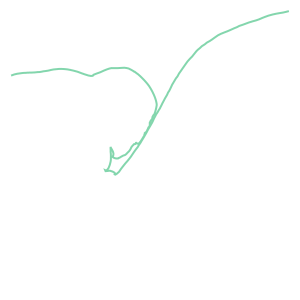

In [12]:
spit.gdf.geometry[0]

In [13]:
spit.x,spit.y,spit.angle = renorm(*rotate_shoreline(*mls2ls(spit.gdf).geometry[0].xy,flipud=1))

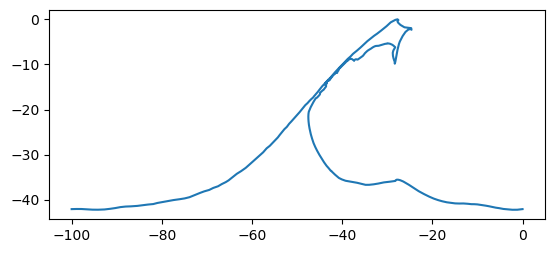

In [14]:
plt.plot(-spit.x,-spit.y)
plt.gca().set_aspect('equal')

In [15]:
writePts2Txt(-spit.x,-spit.y,'data/spit.txt')

<br><br><br><br><br>

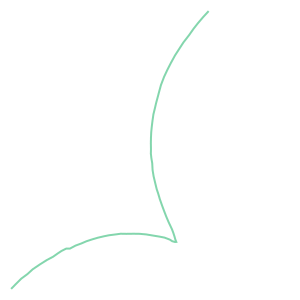

In [16]:
cape.gdf.geometry[0]

In [17]:
cape.x,cape.y,cape.angle = renorm(*rotate_shoreline(*mls2ls(cape.gdf).geometry[0].xy,flipud=1,fliplr=-1))

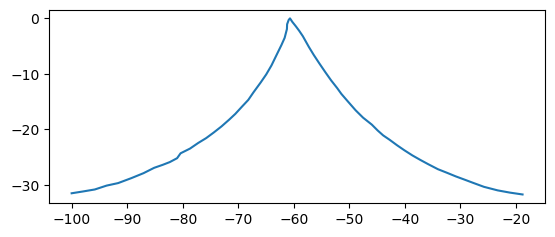

In [18]:
plt.plot(-cape.x[:-8],-cape.y[:-8])
plt.gca().set_aspect('equal')

In [19]:
writePts2Txt(-cape.x[:-8],-cape.y[:-8],'data/cape.txt')